In [2]:
# !pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
import pandas as pd

import re

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import numpy as np

# Data

In [109]:
data = pd.read_csv('/content/ACL_data.csv')
#data = pd.read_csv("https://github.com/mateosuster/nlpPapers/blob/main/code/data/ACL_data.csv")
#data = pd.read_csv("ACL_data.csv")
data.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33811 entries, 0 to 33810
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YEAR       33811 non-null  int64 
 1   TITLE      33811 non-null  object
 2   ABSTRACT   33703 non-null  object
 3   AUTHOR     33768 non-null  object
 4   PUBLISHER  32951 non-null  object
 5   BOOKTITLE  33156 non-null  object
 6   CATEGORY   33811 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


In [110]:
# FILTRO TODOS LOS REGISTROS CON NULOS, DADO Q SOLO SE PIERDE EL 2.5% DE LOS DATOS.
# Y QUIZAS SEA NECESARIO TENER TODOS LOS CAMPOS DE INFO PARA ANALIZAR TOPICOS O GENEROS (SEXO) SEGUN AUTOR, PUBLISHER, ETC
data_original = data #GUARDO LA DATA ORIGINAL ANTES DE QUITARLE LOS N/A, POR LAS DUDAS, PARA COMPARAR RESULTADOS
data = data.dropna()
data.info()
#32245/33811 = se perdieron el 4,63% de los datos.


<class 'pandas.core.frame.DataFrame'>
Int64Index: 32245 entries, 0 to 33724
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YEAR       32245 non-null  int64 
 1   TITLE      32245 non-null  object
 2   ABSTRACT   32245 non-null  object
 3   AUTHOR     32245 non-null  object
 4   PUBLISHER  32245 non-null  object
 5   BOOKTITLE  32245 non-null  object
 6   CATEGORY   32245 non-null  object
dtypes: int64(1), object(6)
memory usage: 2.0+ MB


In [61]:
data.AUTHOR.value_counts()  #18456

Wu, Chuhan  and                    22
Sawhney, Ramit  and                19
Grabar, Natalia  and               17
Ljube{\v{s}}i{\'c}, Nikola  and    17
Liu, Yang  and                     17
                                   ..
Wu, Jinmeng  and                    1
Lee, Gyeongbok  and                 1
Xie, Zhengnan  and                  1
Luthier, Gabriel  and               1
Budhiraja, Navin  and               1
Name: AUTHOR, Length: 18456, dtype: int64

In [ ]:
data.AUTHOR.isna().sum()

0

In [111]:
data['name'] = data['AUTHOR'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip()
#,\s[a-zA-Z]+ 



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [112]:
data.name.value_counts() #8221 unique

, David         141
, Michael       137
, Daniel        136
, Wei           118
, Maria         106
               ... 
, Neetika         1
, Kawaljit        1
, Deepali         1
, Ramchandra      1
, Navin           1
Name: name, Length: 8221, dtype: int64

In [113]:
data.name.isna().sum() #89 
#data.info()#28171 del total 32245 hay 100 que no se que son

89

In [114]:
# saco la coma y espacio de los nombres
data['name'] = data['name'].str.replace(', ', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [115]:
data.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32245 entries, 0 to 33724
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YEAR       32245 non-null  int64 
 1   TITLE      32245 non-null  object
 2   ABSTRACT   32245 non-null  object
 3   AUTHOR     32245 non-null  object
 4   PUBLISHER  32245 non-null  object
 5   BOOKTITLE  32245 non-null  object
 6   CATEGORY   32245 non-null  object
 7   name       32156 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.2+ MB


**PROBAMOS CON GENDER-GUESSER**
https://pypi.org/project/gender-guesser/

In [116]:
#instalamos una libreria de gender guesser https://pypi.org/project/gender-guesser/
!pip install gender_guesser
!pip install xlrd
!pip install openpyxl
import gender_guesser.detector as gender


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
d = gender.Detector()


In [118]:
#aplico sobre todo el dataset
data['Gender'] = data['name'].map(lambda x: d.get_gender(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [119]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32245 entries, 0 to 33724
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   YEAR       32245 non-null  int64 
 1   TITLE      32245 non-null  object
 2   ABSTRACT   32245 non-null  object
 3   AUTHOR     32245 non-null  object
 4   PUBLISHER  32245 non-null  object
 5   BOOKTITLE  32245 non-null  object
 6   CATEGORY   32245 non-null  object
 7   name       32156 non-null  object
 8   Gender     32245 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.5+ MB


In [120]:
data.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,mostly_male
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female


In [121]:
data[data['Gender']=='unknown'].count()
#len(data['Gender']) #32245

YEAR         10540
TITLE        10540
ABSTRACT     10540
AUTHOR       10540
PUBLISHER    10540
BOOKTITLE    10540
CATEGORY     10540
name         10451
Gender       10540
dtype: int64

In [24]:
len(data['Gender']) #32245 total de registros
len(data['name'].unique()) #7774 unicos
data['name'].isna().sum() #89 que no detecta aprox un 12%

89

In [122]:
df = data.groupby('Gender')['Gender'].value_counts()# hay 10540 unknown de los cuales unicos son 4411
df

Gender         Gender       
andy           andy              2882
female         female            5642
male           male             12061
mostly_female  mostly_female      401
mostly_male    mostly_male        719
unknown        unknown          10540
Name: Gender, dtype: int64

In [123]:
data.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,mostly_male
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female


In [ ]:
df1 = data.groupby('Gender')['name'].nunique()
df1

Gender
andy              290
female           1353
male             1927
mostly_female      94
mostly_male       146
unknown          4411
Name: name, dtype: int64

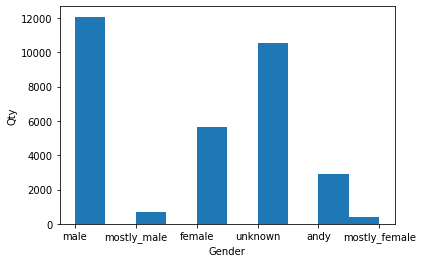

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(data['Gender'])  # density=False would make counts
plt.ylabel('Qty')
plt.xlabel('Gender');

**TRABAJO SOBRE LOS UNKNOWN 4411 unicos**
**API PARA TOMAR LOS NOMBERS UNKNOWN** 

In [ ]:
#guardo los unknown para consultarlos via API
df_unk = data[data['Gender']== 'unknown']
len(df_unk)

10540

In [ ]:
df_unk

In [ ]:
len(df_unk['name'].unique()) #4412

4412

In [ ]:
len(df_unk['name'].unique()


#guardo los unknown en un dataset separado
a = df_unk['name'].unique()
df_unk = pd.DataFrame(a)
df_unk.to_csv("names_unk.csv")

1000

Llamamos a una API para ver los nombres que nos faltan

*   List item
*   List item



In [88]:
import requests

In [ ]:
#api endpoint como solo se podia consultar 1000 por dia lo hicimos en otra pc cambiando la IP

#url= 'https://api.genderize.io'

#list = df_unk['name'].unique()[950:1000]
#dict ={} 


#for i in list:
#  PARAM = {'name': i}
#  response = requests.get(url = url, params = PARAM)
#  data = response.json()
#  gender = data['gender']
#  dict[i]=gender

#guardo el dict en un dataset aparte para trabajarlo separado
#df_names = pd.DataFrame.from_dict(dict, orient="index")
#df_names.to_csv("names950_1949.csv")

In [73]:
#cargo el dataset de los nombres unknown (lo hice por afuera y guarde el dataset)
data_out = pd.read_csv("/content/out.csv")
#data = pd.read_csv("ACL_data.csv")
data_out.head()

,name,gender
0,Minxing,male
1,Shuyan,female
2,Christo,male
3,Prithviraj,male
4,Pedram,male


In [74]:
len(data_out)

4411

In [75]:
data_out.groupby('gender')['gender'].value_counts()

gender  gender
female  female    1258
male    male      2790
Name: gender, dtype: int64

In [78]:
data_out_missing= data_out.isna() #363 nombres missing
data_out.head()

,name,gender
0,Minxing,male
1,Shuyan,female
2,Christo,male
3,Prithviraj,male
4,Pedram,male


**TRABAJO SOBRE LOS ANDY **

Luego de hacer una bariida sobre los nombres que son ANDY (290 unicos) vemos que parecieran ser nombres asiaticos en principio. Por esto decidimos una vez más llamar a la API a ver la devolucion de los mismos.

In [79]:
data_andy=data[data['Gender']=='andy']
data_andy.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender
41,2022,Multiplex Anti-{A}sian Sentiment before and du...,COVID-19 has disproportionately threatened min...,"Lin, Hao and",Association for Computational Linguistics,Proceedings of the 12th Workshop on Computatio...,INPROCEEDINGS,Hao,andy
51,2022,E}nglish-{M}alay Word Embeddings Alignment for...,The main challenge in English-Malay cross-ling...,"Lim, Ying Hao and",Association for Computational Linguistics,Proceedings of the 12th Workshop on Computatio...,INPROCEEDINGS,Ying,andy
60,2022,IUCL} at {WASSA} 2022 Shared Task: A Text-only...,"Our system, IUCL, participated in the WASSA 20...","Chen, Yue and",Association for Computational Linguistics,Proceedings of the 12th Workshop on Computatio...,INPROCEEDINGS,Yue,andy
61,2022,Continuing Pre-trained Model with Multiple Tra...,Emotion is the essential attribute of human be...,"Li, Bin and",Association for Computational Linguistics,Proceedings of the 12th Workshop on Computatio...,INPROCEEDINGS,Bin,andy
67,2022,Prompt-based Pre-trained Model for Personality...,This paper describes the LingJing team{'}s met...,"Li, Bin and",Association for Computational Linguistics,Proceedings of the 12th Workshop on Computatio...,INPROCEEDINGS,Bin,andy


In [87]:
#len(data_andy)#2882
#len(data_andy['name'].unique())#290
#a=data_andy['name'].unique()
#andy = pd.DataFrame(a)
andy.columns= ['name']# cambio nombre de columna
andy.head()

,name
0,Hao
1,Ying
2,Yue
3,Bin
4,Yang


In [89]:
#llamar a la API para los caso ANDY

url= 'https://api.genderize.io'

list = andy['name']
dict ={} 


for i in list:
  PARAM = {'name': i}
  response = requests.get(url = url, params = PARAM)
  data = response.json()
  gender = data['gender']
  dict[i]=gender

#guardo el dict en un dataset aparte para trabajarlo separado
df_andy = pd.DataFrame.from_dict(dict, orient="index")
df_andy.to_csv("andy.csv")

In [96]:
df_andy = df_andy.reset_index()
df_andy.columns=['name','gender2']
df_andy.head()

,name,gender2
0,Hao,male
1,Ying,female
2,Yue,female
3,Bin,male
4,Yang,male


In [98]:
#len(df_andy)#290
df_andy.groupby('gender2')['gender2'].value_counts()

gender2  gender2
female   female      82
male     male       208
Name: gender2, dtype: int64

In [ ]:


for i in df_join['YEAR']:
  
  resultado 
  if i >2015: 
    resultado = i
  elif i > 2010:
    resultado = 2010
  elif i >2000:
    resultado = 2000
  else:
    resultado = 1999 
  df_join['s'] = pd.DataFrame({'year_f':resultado})


**Levanto los datasets de ACL por gender**
https://nlp.stanford.edu/pubs/vogeljurafsky12.pdf

https://nlp.stanford.edu/projects/gender/



In [39]:
data_male = pd.read_csv("/content/acl-male.txt", delimiter="\t")
data_female = pd.read_csv("/content/acl-female.txt", delimiter="\t")
data_unknow = pd.read_csv("/content/acl-unknown.txt", delimiter="\t")


In [44]:
data_male.columns =['name', 'gender3']# incluyo nombre de columnas
data_male['male']='male' #agrego columna de genero
data_male['name'] = data_male['name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
data_male['name'] = data['name'].str.replace(', ', '') # le saco la coma
data_male.head() 

,name,gender3
0,Peter,male
1,Nick,male
2,Ryan,male
3,Gregory,male
4,Laetitia,male


In [46]:
data_female['gender3']='female' #agrego columna de genero
data_female.columns =['name', 'gender3']# cambio nombre de columna
data_female['name'] = data_female['name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
data_female['name'] = data_female['name'].str.replace(', ', '') # le saco la coma
data_female.head() 


,name,gender3
0,Anne,female
1,Andrea,female
2,Alicia,female
3,Geetha,female
4,Zahra,female


In [49]:
data_unknow['gender3']='unknown' #agrego columna de genero
data_unknow.head()
#data_unknow.columns =['name', 'gender3']# cambio nombre de columna
#data_unknow['name'] = data_uknow['name'].str.extract('(,\s[a-zA-Z]+)', expand=False).str.strip() # me quedo con el primer nombre
#data_unknow['name'] = data_unknow['name'].str.replace(', ', '') # le saco la coma
#data_unknow.head() 


,name,gender3
0,&#199,unknown
1,&#213,unknown
2,&#214,unknown
3,&#216,unknown
4,&#225,unknown


In [51]:
#len(data_female)#3358
len(data_male) #8572

8572

In [53]:
names = pd.concat([data_female, data_male], axis=0)
names.head()

,name,gender3
0,Anne,female
1,Andrea,female
2,Alicia,female
3,Geetha,female
4,Zahra,female


In [54]:
len(names)

11930

**UNO TODOS LOS DATASETS**

data = original 

data_unk = los unknown que obtuvimos con la API

df_andy = los andy del dataset data lo consultamos con la API

names = dataset que tomamos del ACL


In [131]:
#len(data) #32245
#len(data_out) #4411
#len(df_andy) # 290
#len(names) #11930

11930

In [148]:
#dfs =[data,data_out]
df_1=pd.merge(data,data_out, on="name", how= "left")

In [150]:
df_1.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender,gender
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male,NaN
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male,NaN
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,mostly_male,NaN
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male,NaN
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female,NaN


In [151]:
df_2=pd.merge(df_1,df_andy, on="name", how= "left")

In [153]:
#df_2.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender,gender,gender2
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male,NaN,NaN
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male,NaN,NaN
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,mostly_male,NaN,NaN
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male,NaN,NaN
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female,NaN,NaN


In [159]:
#me quedo solo con los unique de names para poder hacer el merge

names_u=names.drop_duplicates(subset=['name'])#5249
len(names_u)

5249

In [187]:
df_3=pd.merge(df_2,names_u, on="name", how= "left")
len(df_3)

32245

In [188]:
df_3.head()

,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender,gender,gender2,gender3
0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male,NaN,NaN,male
1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male,NaN,NaN,male
2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,mostly_male,NaN,NaN,male
3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male,NaN,NaN,male
4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female,NaN,NaN,male


In [177]:
df_3.groupby('Gender')['Gender'].value_counts()

Gender         Gender       
andy           andy              2882
female         female            5642
male           male             12061
mostly_female  mostly_female      401
mostly_male    mostly_male        719
unknown        unknown          10540
Name: Gender, dtype: int64

In [203]:
df_3.loc[df_3["Gender"] == "mostly_male", "Gender"] = 'male' #cambio mostly_male por male
df_3.loc[df_3["Gender"] == "mostly_female", "Gender"] = 'female'#cambio mostly_female por female

In [204]:
df_3.groupby('Gender')['Gender'].value_counts()

Gender   Gender 
andy     andy        2882
female   female      6043
male     male       12780
unknown  unknown    10540
Name: Gender, dtype: int64

In [205]:
df_3.to_csv('df_3.csv')

El dataset final lo trabajamos por afuera para ver puntualmente que nos traia

In [4]:
data_final = pd.read_csv("/content/df_3 _tunned.csv")

In [5]:
data_final.head()

,Unnamed: 0,YEAR,TITLE,ABSTRACT,AUTHOR,PUBLISHER,BOOKTITLE,CATEGORY,name,Gender_Guesser,Gender_API,Gender_Andy_API,Gender_ACL,Gender=gender3,gender_final_form,gender_final
0,0,2022,A Systematic Survey of Text Worlds as Embodied...,Text Worlds are virtual environments for embod...,"Jansen, Peter",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Peter,male,NaN,NaN,male,True,male,male
1,1,2022,A Minimal Computational Improviser Based on Or...,A prototype system for playing a minimal impro...,"Montfort, Nick and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Nick,male,NaN,NaN,male,True,male,male
2,2,2022,Craft an Iron Sword: Dynamically Generating In...,Non-Player Characters (NPCs) significantly enh...,"Volum, Ryan and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Ryan,male,NaN,NaN,male,True,male,male
3,3,2022,A Sequence Modelling Approach to Question Answ...,Interactive Question Answering (IQA) requires ...,"Furman, Gregory and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Gregory,male,NaN,NaN,male,True,male,male
4,4,2022,Automatic Exploration of Textual Environments ...,The purpose of this extended abstract is to di...,"Teodorescu, Laetitia and",Association for Computational Linguistics,Proceedings of the 3rd Wordplay: When Language...,INPROCEEDINGS,Laetitia,female,NaN,NaN,male,False,female,female


In [6]:
data_final.loc[data_final["gender_final"] == "Y", "gender_final"] = 'unknown' #cambio mostly_male por male

**GRAFICOS DE GENDER**

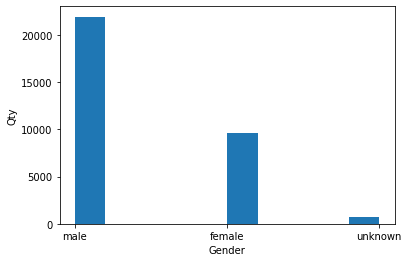

In [7]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(data_final['gender_final'])  # density=False would make counts
plt.ylabel('Qty')
plt.xlabel('Gender');

In [50]:
table=data_final.value_counts(['YEAR', 'gender_final'])

In [51]:
table

YEAR  gender_final
2020  male            4430
2021  male            4060
2019  male            2986
2018  male            2391
2022  male            2120
                      ... 
1997  female             1
1995  unknown            1
1997  unknown            1
1995  female             1
1993  unknown            1
Length: 83, dtype: int64

In [61]:
#gender per year

per_year = pd.crosstab(data_final.YEAR, data_final.gender_final)
per_year

gender_final,female,male,unknown
YEAR,,,
1989,2,24,2
1991,3,24,0
1993,5,35,1
1995,1,20,1
1997,1,25,1
1998,24,23,4
2000,14,49,4
2001,16,38,5
2002,20,60,7


In [ ]:
#reseteo el index para quedarme con la columna año
per_year= per_year.reset_index()
per_year.info()

In [80]:
#creamos el total por año
per_year['total'] = per_year['female'] + per_year['male'] + per_year['unknown']


gender_final,YEAR,female,male,unknown,total
0,1989,2,24,2,28
1,1991,3,24,0,27
2,1993,5,35,1,41
3,1995,1,20,1,22
4,1997,1,25,1,27


In [82]:
#creo % por genero por año
per_year['female_%'] = per_year['female'] / per_year['total'] * 100
per_year['male_%'] = per_year['male'] / per_year['total'] *100
per_year['unknown_%'] = per_year['unknown'] / per_year['total'] *100
per_year.head()

gender_final,YEAR,female,male,unknown,total,female_%,male_%,unknown_%
0,1989,2,24,2,28,7.142857,85.714286,7.142857
1,1991,3,24,0,27,11.111111,88.888889,0.000000
2,1993,5,35,1,41,12.195122,85.365854,2.439024
3,1995,1,20,1,22,4.545455,90.909091,4.545455
4,1997,1,25,1,27,3.703704,92.592593,3.703704


In [83]:
type(per_year)

pandas.core.frame.DataFrame

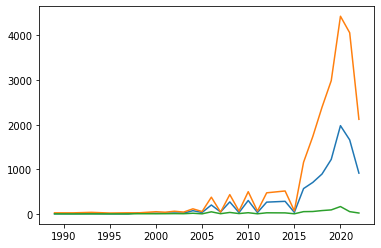

In [79]:
#gender per year

import numpy as np
import matplotlib.pyplot as plt

Y = per_year['female']
M = per_year['male']
Z= per_year['unknown']
X = per_year['YEAR']

fig, ax = plt.subplots()
ax.plot(X,Y,X,M,X,Z)
fig.show()

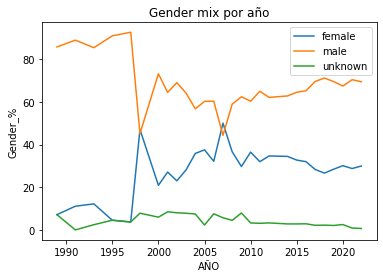

In [95]:
Y = per_year['female_%']
M = per_year['male_%']
Z= per_year['unknown_%']
X = per_year['YEAR']

fig, ax = plt.subplots()
ax.plot(X,Y, label='female')
ax.plot(X,M, label='male')
ax.plot(X,Z, label='unknown')
ax.set_title('Gender mix por año')
ax.set_xlabel('AÑO') 
ax.set_ylabel('Gender_%') 
ax.legend(loc='best')
fig.show()

In [121]:
per_year.reset_index()
per_year.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   YEAR       28 non-null     int64  
 1   female     28 non-null     int64  
 2   male       28 non-null     int64  
 3   unknown    28 non-null     int64  
 4   total      28 non-null     int64  
 5   female_%   28 non-null     float64
 6   male_%     28 non-null     float64
 7   unknown_%  28 non-null     float64
dtypes: float64(3), int64(5)
memory usage: 1.9 KB


In [134]:
per_year.set_index('YEAR')
#per_year.head()

gender_final,female,male,unknown,total,female_%,male_%,unknown_%
YEAR,,,,,,,
1989,2,24,2,28,7.142857,85.714286,7.142857
1991,3,24,0,27,11.111111,88.888889,0.000000
1993,5,35,1,41,12.195122,85.365854,2.439024
1995,1,20,1,22,4.545455,90.909091,4.545455
1997,1,25,1,27,3.703704,92.592593,3.703704
1998,24,23,4,51,47.058824,45.098039,7.843137
2000,14,49,4,67,20.895522,73.134328,5.970149
2001,16,38,5,59,27.118644,64.406780,8.474576
2002,20,60,7,87,22.988506,68.965517,8.045977


In [ ]:
per_year.head()

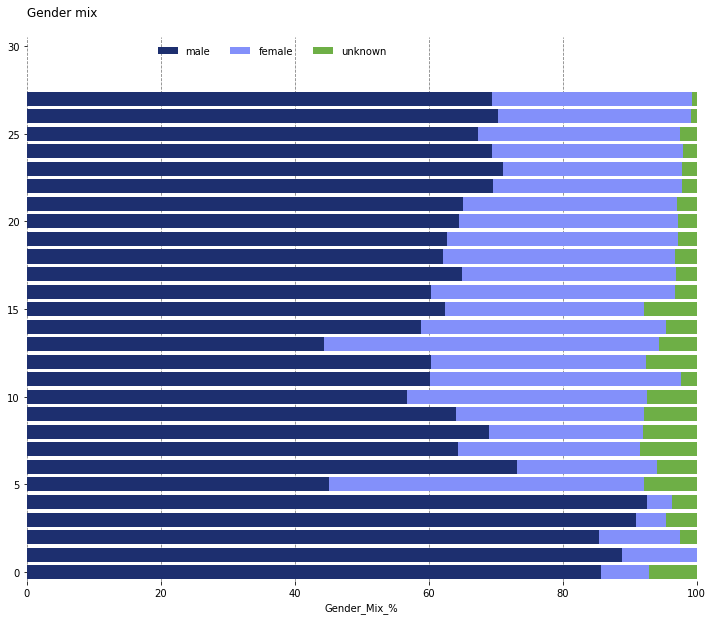

In [136]:


fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
labels = ['male', 'female', 'unknown']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(per_year) * [0]
for idx, name in enumerate(fields):
    plt.barh(per_year.index, per_year[name], left = left, color=colors[idx])
    left = left + per_year[name]
# title, legend, labels
plt.title('Gender mix\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Gender_Mix_%')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

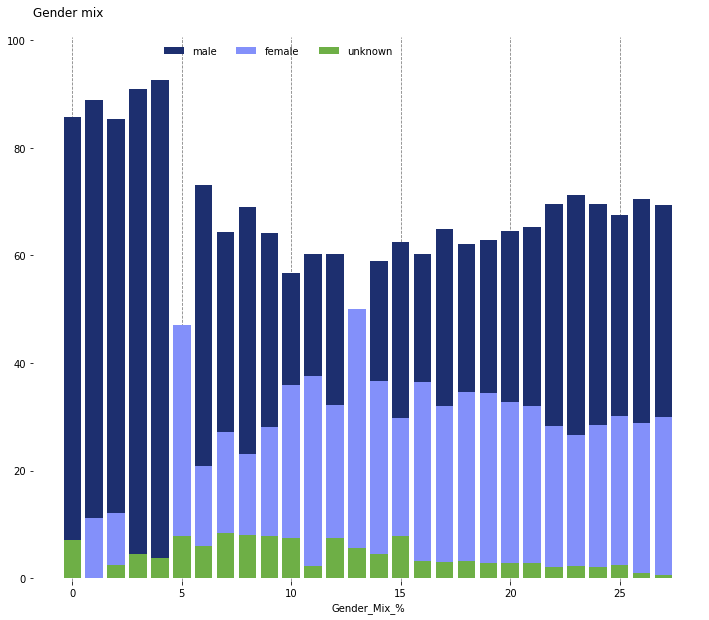

In [138]:


fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']
labels = ['male', 'female', 'unknown']
# figure and axis
fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
left = len(per_year) * [0]
for idx, name in enumerate(fields):
    plt.bar(per_year.index, per_year[name], color=colors[idx])
    
# title, legend, labels
plt.title('Gender mix\n', loc='left')
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Gender_Mix_%')
# remove spines
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# adjust limits and draw grid lines
plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()

IndexError: ignored

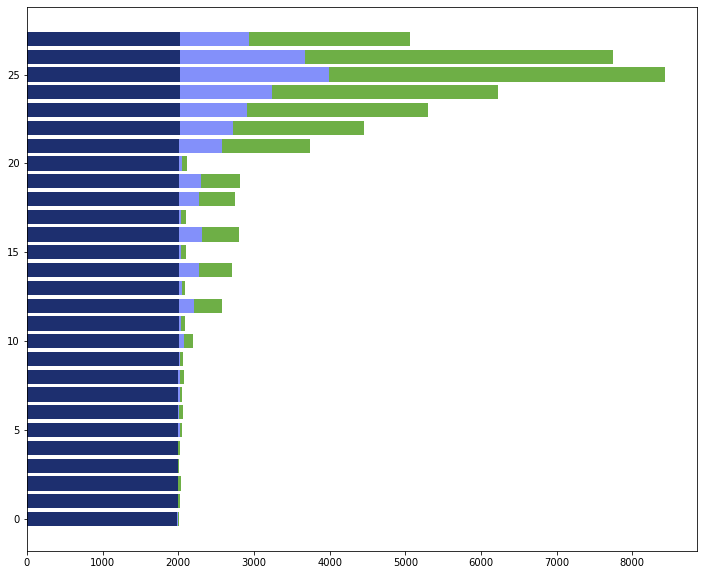

In [141]:
# variables
fields = ['male_%','female_%','unknown_%']
colors = ['#1D2F6F', '#8390FA', '#6EAF46']

title = 'Video Game Sales By Platform and Region\n'
subtitle = 'Proportion of Games Sold by Region'
def plot_stackedbar_p(per_year, labels, colors, title, subtitle):
    fields = per_year.columns.tolist()
    
    # figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 10))
# plot bars
    left = len(per_year) * [0]
    for idx, name in enumerate(fields):
        plt.barh(per_year.index, per_year[name], left = left, color=colors[idx])
        left = left + per_year[name]
# title and subtitle
    plt.title(title, loc='left')
    plt.text(0, ax.get_yticks()[-1] + 0.75, subtitle)
# legend
    plt.legend(labels, bbox_to_anchor=([0.58, 1, 0, 0]), ncol=4, frameon=False)
# remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
# format x ticks
    xticks = np.arange(0,1.1,0.1)
    xlabels = ['{}%'.format(i) for i in np.arange(0,101,10)]
    plt.xticks(xticks, xlabels)
# adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.xaxis.grid(color='gray', linestyle='dashed')
plt.show()
    
plot_stackedbar_p(per_year, labels, colors, title, subtitle)

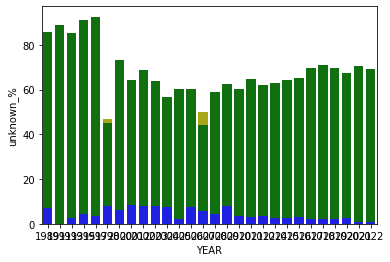

In [107]:
import seaborn as sns

bar_plot1 = sns.barplot(x='YEAR', y='female_%', data=per_year, label="female_%", color="y")
bar_plot2 = sns.barplot(x='YEAR', y='male_%', data=per_year, label="male_%", color="g")
bar_plot3 = sns.barplot(x='YEAR', y='unknown_%', data=per_year, label="unknown_%", color="b")

plt.show()

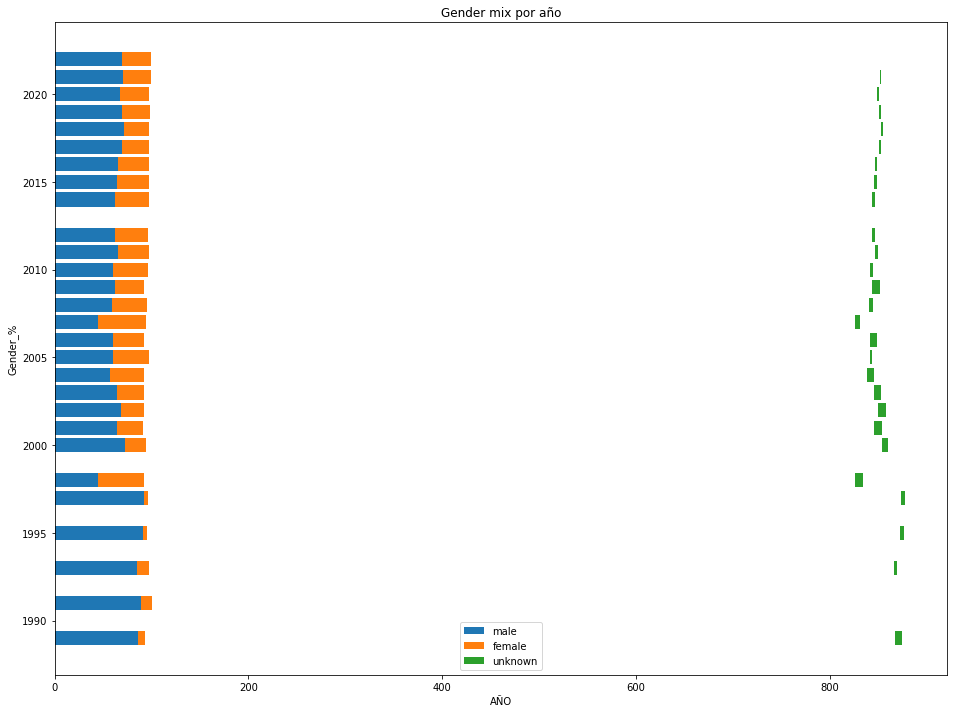

In [133]:
# Define Data

año = per_year['YEAR']
female = per_year['female_%']
male = per_year['male_%']
unknown = per_year['unknown_%']
a = female + male

# Define height of stacked chart


h = 1

# Plot stacked bar chart



# Display
fig, ax = plt.subplots(1, figsize=(16, 12))
ax.barh(año, male, label = 'male')
ax.barh(año, female, left=male, label = 'female')
ax.barh(año, unknown, left=sum(female,male), label = 'unknown')


ax.set_title('Gender mix por año')
ax.set_xlabel('AÑO') 
ax.set_ylabel('Gender_%') 
ax.legend(loc='best')



plt.show()